In [1]:
import random
from typing import List

import numpy as np
import einops
import matplotlib.pyplot as plt
import torch
from torchtyping import TensorType, patch_typeguard
from tqdm.notebook import tqdm

from hand import show_transformer, Transformer, show_activations, set_debug
from exos import EXOS

%load_ext autoreload
%autoreload 2

In [14]:
PB = "IfThenElse"
EXO = EXOS[PB]
tokenizer = EXO.tokenizer
def gen_goal(n: int):
    xs, ys = EXO.generate(n)
    xs = EXO.tokenizer.encode(xs)
    ys = EXO.tokenizer.encode(ys, pad=False)
    return xs, ys
# def gen_goal(n: int):
#     xs ["00", "01", "10", "11"]
#     ys = ["0", "1", "1", "0"]
#     xs = EXO.tokenizer.encode(xs)
#     ys = EXO.tokenizer.encode(ys, pad=False)
#     return xs, ys
EXO

IfThenElse
Input: XYZ. Complete by Y if X == 1 otherwise by Z.

Alphabet: 0: ''  1: 0  2: 1
Input length: 3
Examples:
  000 → 0
  000 → 0
  100 → 0
  010 → 0
  101 → 0

In [ ]:
from torch.nn import Parameter
from hand import pprint_2d_tensor, set_debug


epochs = 2000
batch_size = 4
lr = 0.01
weight_decay = 0.001
depth = 1
heads = 1
embedding_size = 5

# pos_encoder=torch.eye(tokenizer.max_len, embedding_size)
pos_encoder = torch.cat([
    torch.zeros(tokenizer.max_len, 3),
    torch.eye(tokenizer.max_len),
    torch.zeros(tokenizer.max_len, embedding_size - tokenizer.max_len - 3),
    ], dim=1)
pprint_2d_tensor(pos_encoder)
transformer = Transformer(
    voc_size=tokenizer.vocab_size, 
    embedding_size=embedding_size,
    depth=depth,
    heads=heads,
    pos_encoder=pos_encoder,
    mlp_dims=()
)

if "Force (un)embedding":
    # transformer.embedding.weight = Parameter(
    #     torch.eye(*transformer.embedding.weight.shape), requires_grad=False)
    transformer.embedding.weight = Parameter(
        5 * torch.cat([
            torch.tensor([[0], [1], [-1]]),
            torch.zeros(tokenizer.vocab_size, embedding_size - 1),
        ], dim=1), requires_grad=False)
    transformer.unembedding = Parameter(transformer.embedding.weight.T, requires_grad=False)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr, weight_decay=weight_decay)

set_debug()

perfs = []
# Training
for epoch in tqdm(range(epochs)):
    xs, ys = gen_goal(batch_size)
    preds = transformer(xs)
    lost = loss(preds, torch.nn.functional.one_hot(ys, tokenizer.vocab_size).squeeze(1).float())
    lost.backward()
    optimizer.step()
    optimizer.zero_grad()

    perfs.append(lost.item())
    if epoch % (epochs // 10) == (epochs // 10) - 1:
        print(f"Epoch {epoch+1} loss: {lost}")

    if lost.item() < 0.55:
        break

# plt.plot(np.convolve(perfs, np.ones(30)/30, mode='valid'))
plt.plot(perfs)
EXO.test(transformer, 1000)

In [ ]:
# Testing
EXO.test(transformer, 1000)

In [ ]:
saved = transformer

# Inspection of the model

In [ ]:
show_transformer(transformer)

In [ ]:
show_activations(transformer, torch.tensor([[2, 1]]))

# Comparision with hand made

IfThenElse
Input: XYZ. Complete by Y if X == 1 otherwise by Z.

Alphabet: 0: ''  1: 0  2: 1
Input length: 3
Examples:
  101 → 0
  101 → 0
  101 → 0
  011 → 1
  101 → 0
000 → 0         	'': 0.00  0: 1.00  1: 0.00
011 → 1         	'': 0.03  0: 0.03  1: 0.94
101 → 0         	'': 0.00  0: 1.00  1: 0.00
110 → 1         	'': 0.00  0: 0.00  1: 1.00
010 → 0         	'': 0.00  0: 1.00  1: 0.00
011 → 1         	'': 0.03  0: 0.03  1: 0.94
100 → 0         	'': 0.03  0: 0.93  1: 0.03
111 → 1         	'': 0.00  0: 0.00  1: 1.00
001 → 1         	'': 0.00  0: 0.00  1: 1.00
011 → 1         	'': 0.03  0: 0.03  1: 0.94
Loss: 0.56  Accuracy: 1000 / 1000


(1000, 0.5623834133148193)

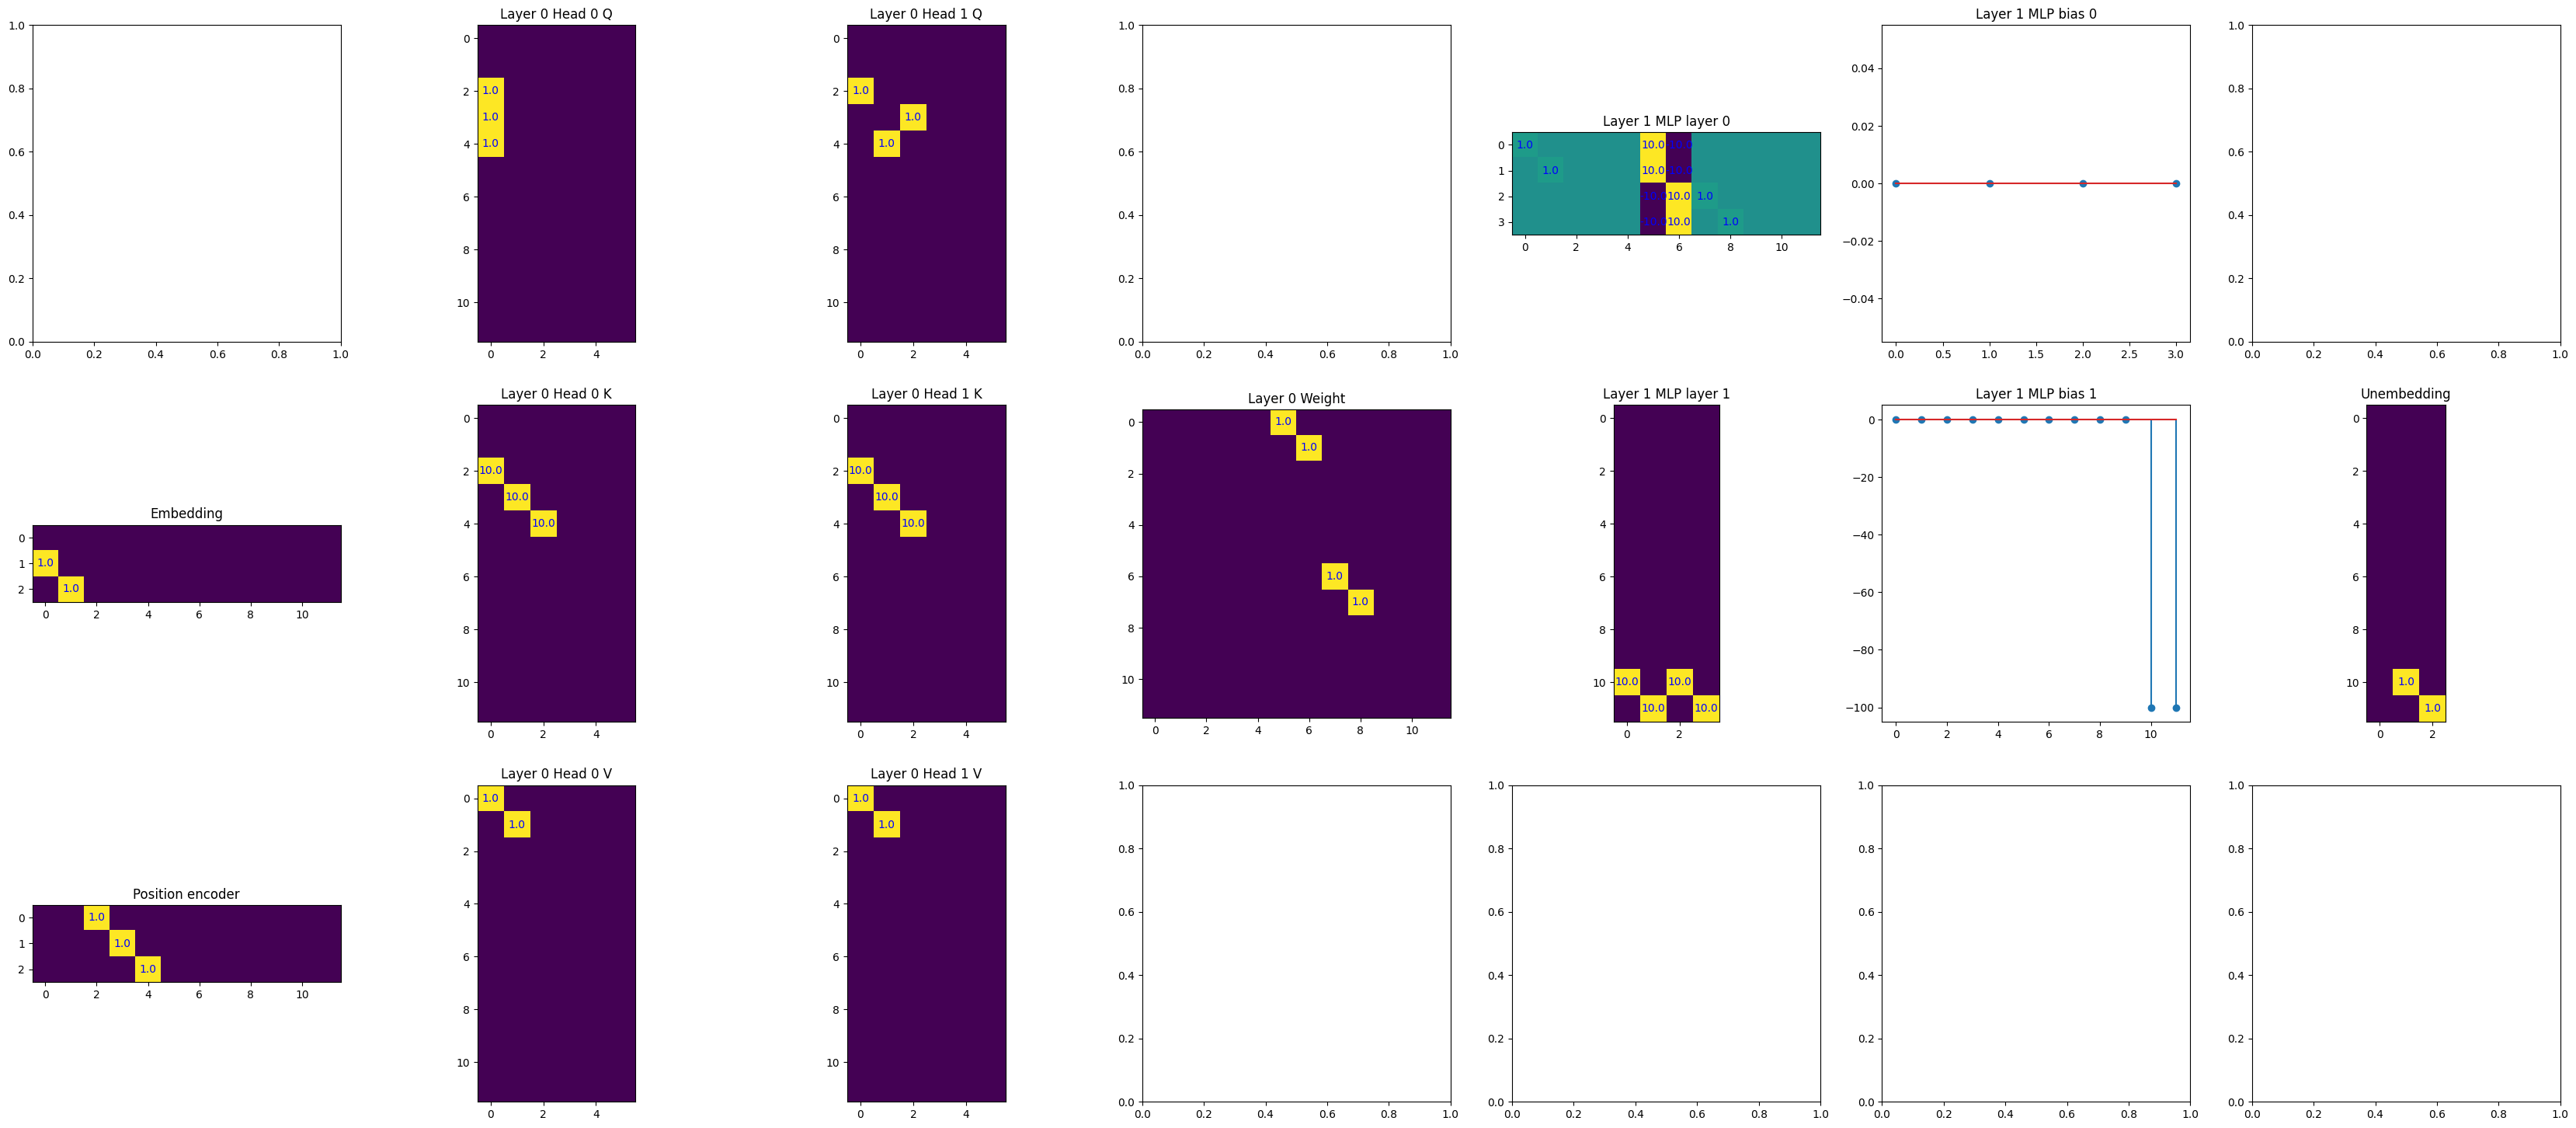

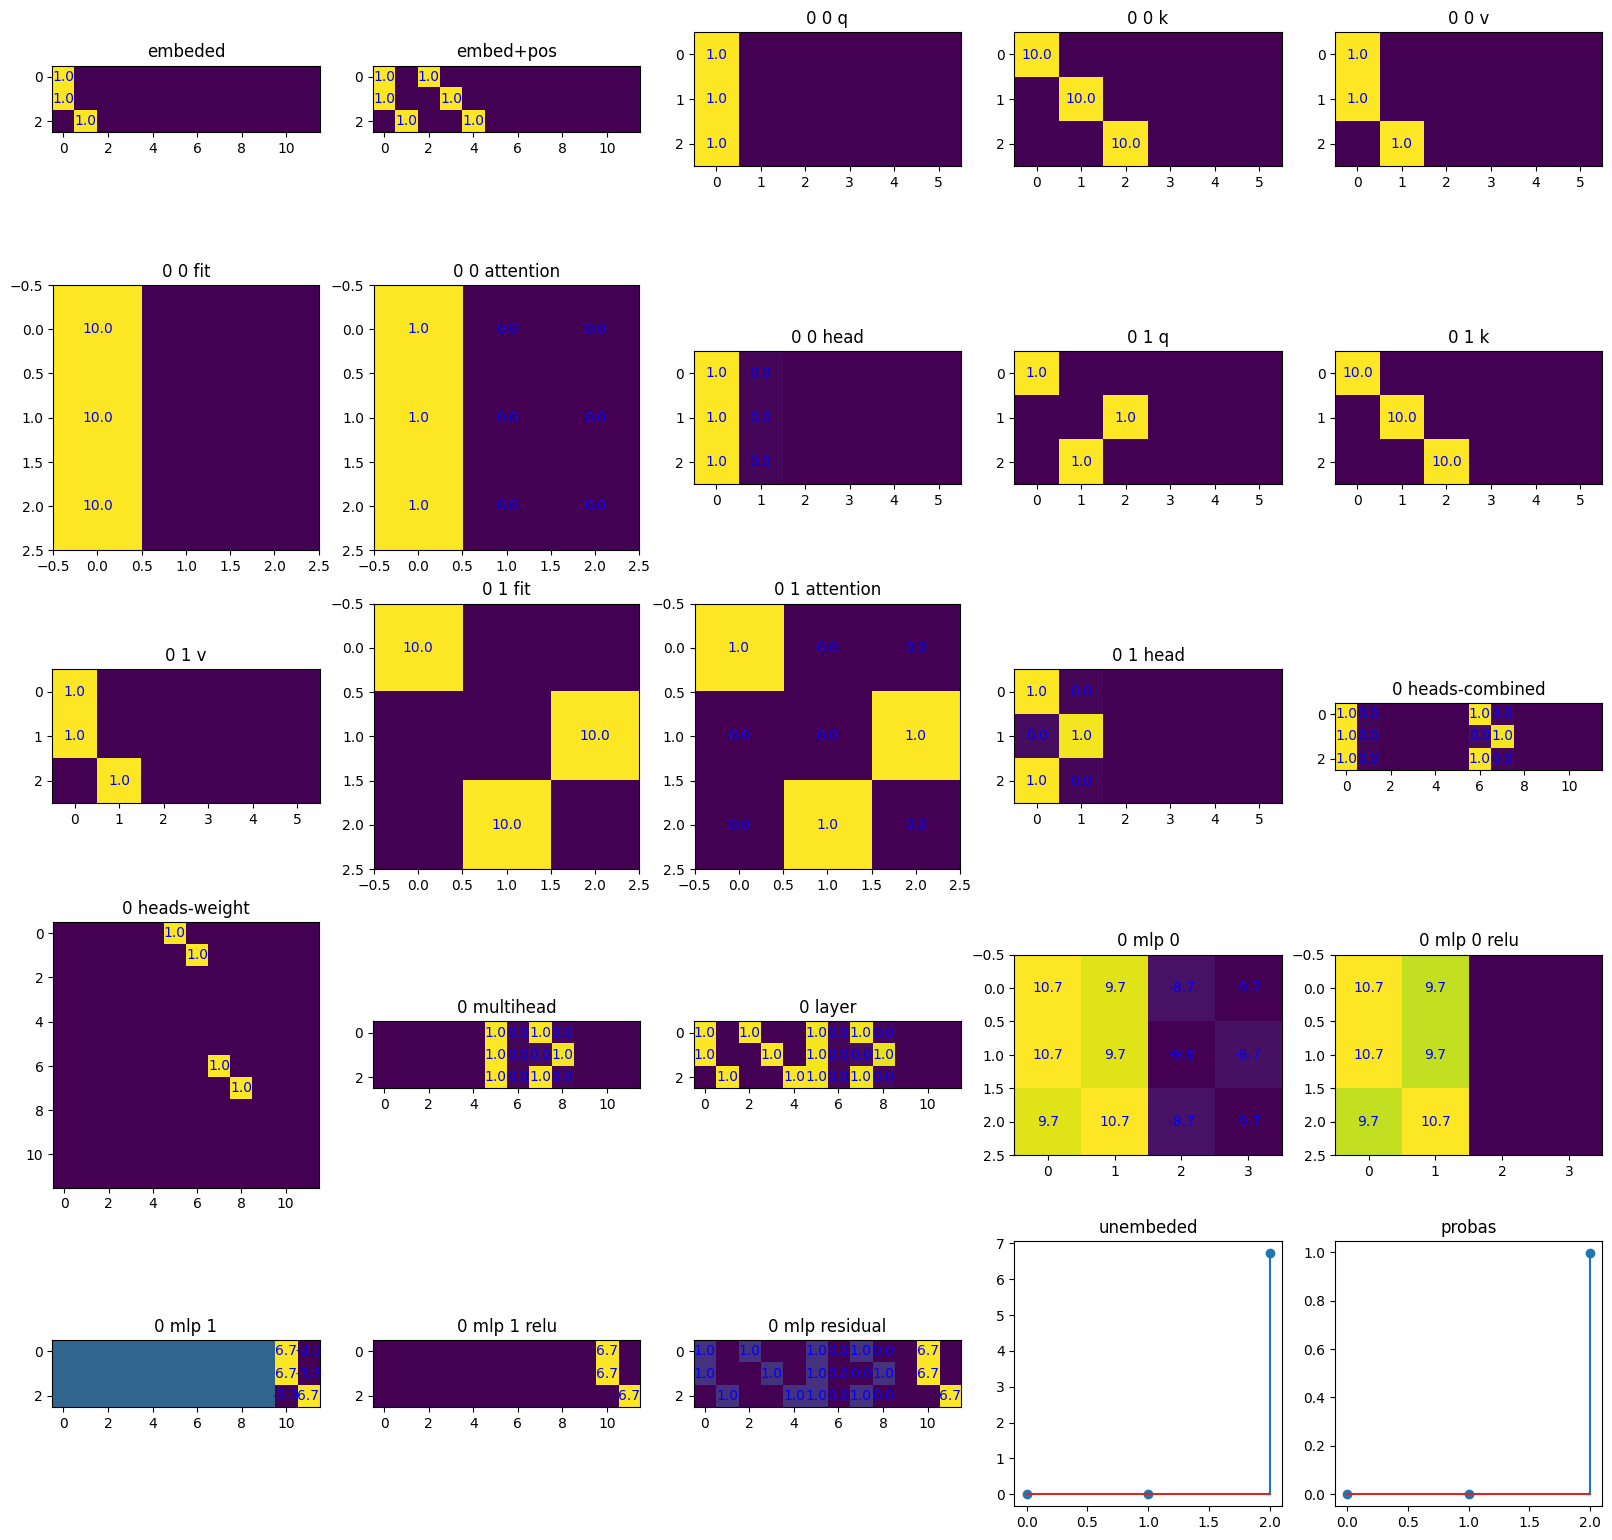

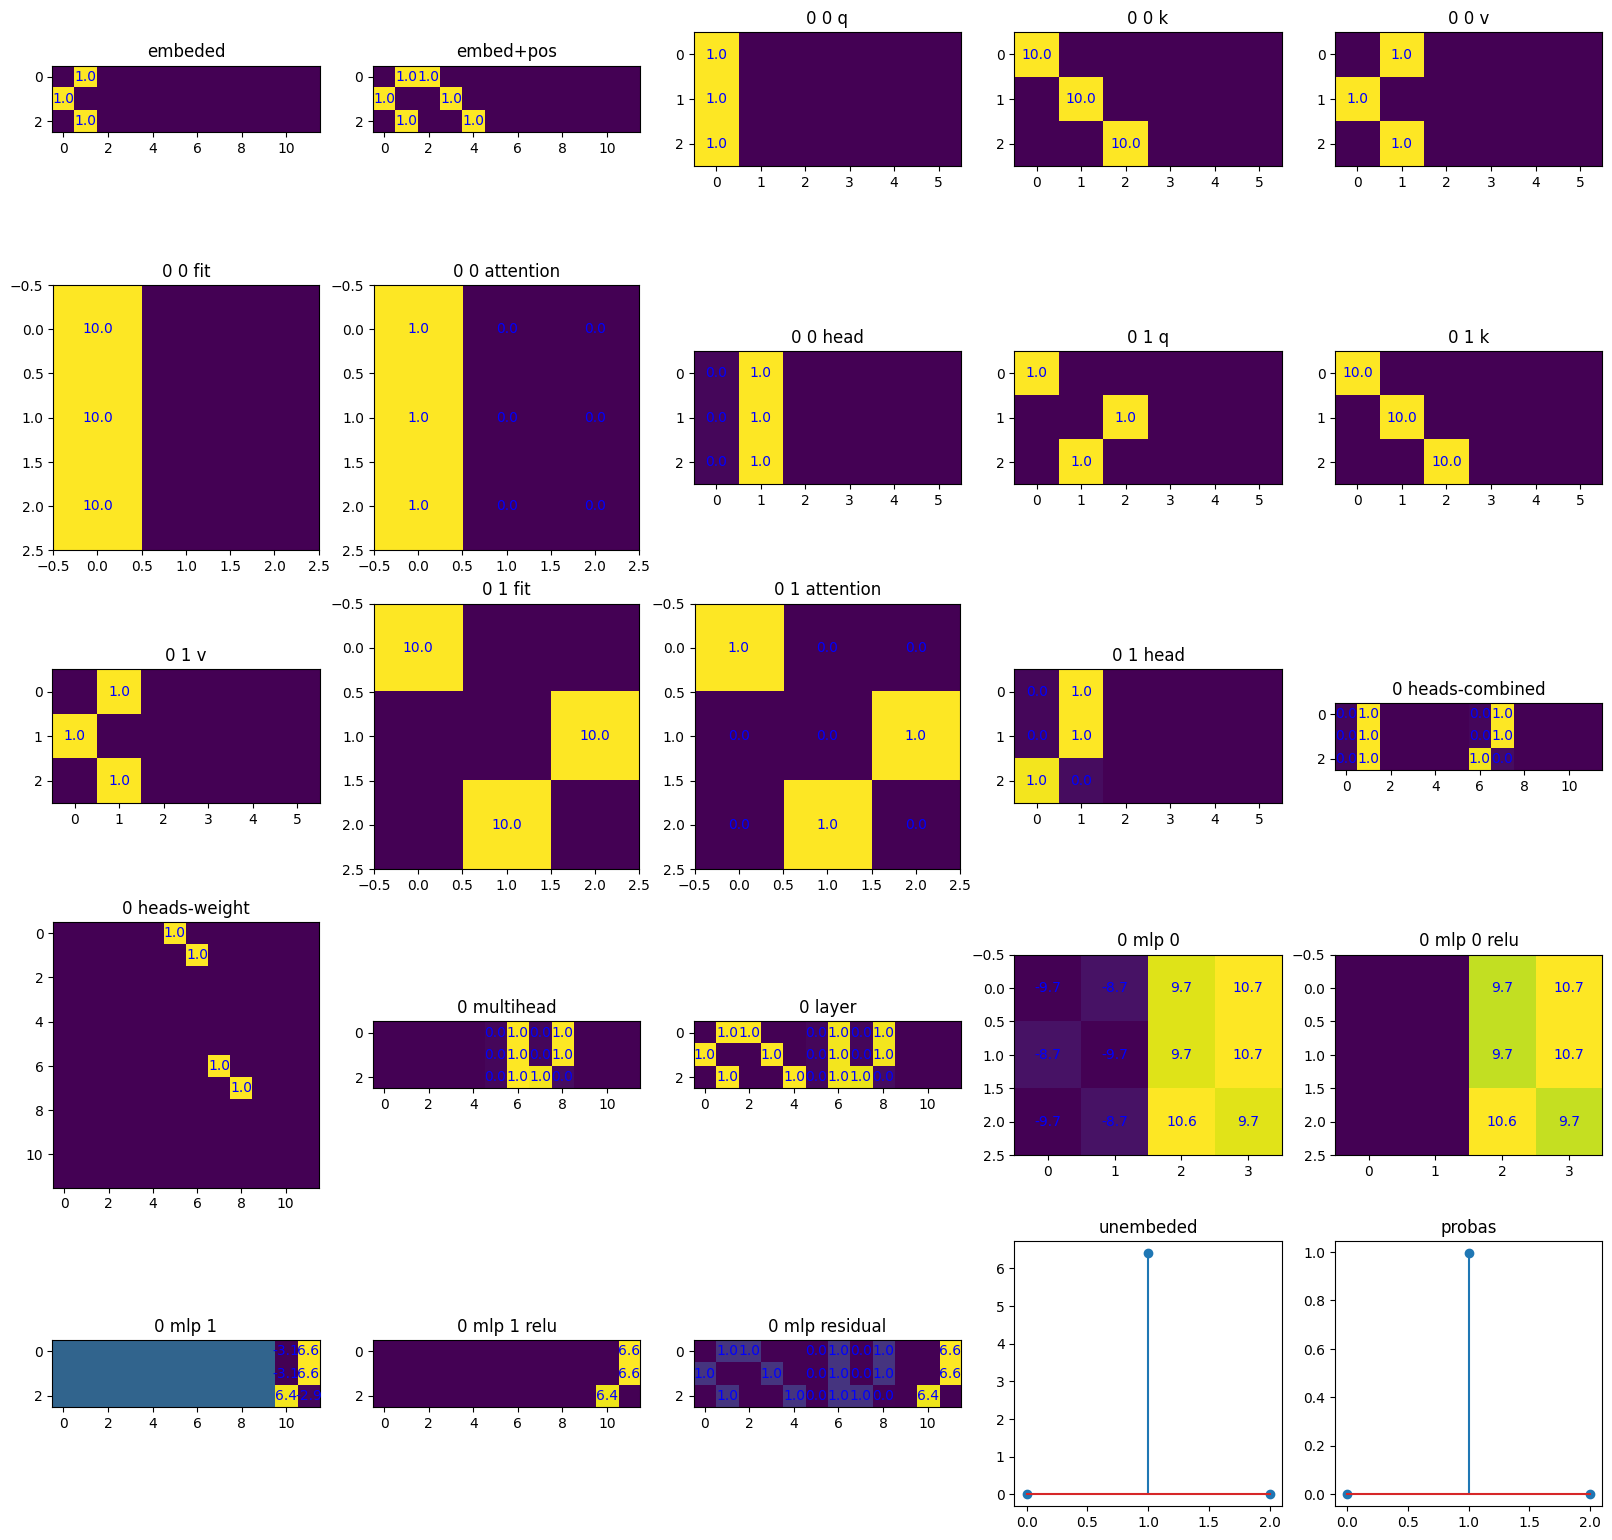

In [20]:
# from solutions.reverse import reverse_better as reverse
from solutions.if_then_else import if_then_else, EXO

print(EXO)

model = if_then_else()

set_debug()
show_transformer(model, scale=6)
show_activations(model, EXO.tokenizer.encode(["001"]))
show_activations(model, EXO.tokenizer.encode(["101"]))

EXO.test(model, 1000)
